# Описание проекта

Нужно подготовить прототип модели машинного обучения для компания, которая разрабатывает решения для эффективной работы промышленных предприятий. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

# 1. Подготовка данных

### 1.1. Откройте файлы и изучите их.

In [2]:
# Импортирование библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Импортируем метрики
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Ипопортируем модели для обучения
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Отключим надоедливые предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Прочитаем датасеты и запишем их в переменные
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')
train_data = pd.read_csv('/datasets/gold_recovery_train.csv')
test_data = pd.read_csv('/datasets/gold_recovery_test.csv')

Теперь посмотрим на наши датасеты, сколько значений, есть ли пропуски, какие типы столбцов, да и в принице с чем предстоит иметь дело. Начнем с исходного датасета, и далее рассмотрим оставшиеся два.

In [4]:
# Посмотрим в целом как выглядят наши даши таблицы
pd.set_option('display.max_columns', None)
full_data.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

22716 значений, 87 столбцов, причем названия не самые дружелюбные для понимания). Типы данных у нас подходящие во всех столбцах, кроме первого, так как там хранится дата, а сохранена она в строковом формате. Так же присутствуют пропуски, причем в разных столбцах, разное количество пропущенных значений. 
Посмотрим два оставшихся датафрейма, которые по сути являются частями данного (из описания проекта)

In [6]:
train_data.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Ситуация полностью аналогичная, только значений поменьше, примерно 75% от исходного датасета. А что же за тестовый датасет.

In [8]:
test_data.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

А вот в данном датасете, помимо того что значений еще меньше, 25% от исходного, но количество признаков сократилось до 53 (так же присутствуют пропуски, и тип столбца с датой сохранен как строковый). Так же в данном датасете отсутвуют и столбцы с целевыми признаками - 'rougher.output.recovery' и 'final.output.recovery', но зато эти данные есть в исходном датасете, откуда их мы их просто добавим в тествый датасет.

### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

Данные мы посмотрели, "больные точки" намечены. Теперь проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака 'rougher.output.recovery'. Перед проверочным рассчетом, стоит обратить внимание, что часть значений в стоблце 'rougher.output.recovery' пропущена, поэтому удалим все пропуски в датасете train_data. Ведь чтобы понять, правильные ли у нас данные, нужно сравнивать исходные значения с полученными нами при рассчете вручную. Если же заполнять пропуски, то это уже будут не исходные данные и они могут искажать картинку. После будем рассчитывать в ручную эффективность обогащения по формуле, которая есть в условии задачи.

In [10]:
# Создадим временный датасет для проверки правильности расчета эффективности обогащения и из
# этого датасета удалим все строки в которых пропущено значение признака 
# 'rougher.output.recovery'
train_data_temporary = train_data.copy().dropna(subset=['rougher.output.recovery'])

In [11]:
# Создадим отдельный столбец во вновь созданном датасете, куда поместим рассчитанный по формуле
# показатель эффективности обогащения
train_data_temporary['recovery_manual'] = (train_data_temporary['rougher.output.concentrate_au'] * 
           (train_data_temporary['rougher.input.feed_au'] - 
            train_data_temporary['rougher.output.tail_au'])
           ) / (train_data_temporary['rougher.input.feed_au'] * 
                (train_data_temporary['rougher.output.concentrate_au'] - 
                 train_data_temporary['rougher.output.tail_au'])
               ) * 100

In [12]:
# Воспользуемся библиотекой sklearn и метрикой МАЕ чтобы сравнить исходные данные и те, что мы
# получили при ручном рассчете
rougher_mae = mean_absolute_error(train_data_temporary['rougher.output.recovery'], 
                    train_data_temporary['recovery_manual'])
rougher_mae

9.444891926100695e-15

Итог, мы получили значение близкое к 0 - а это означает что можно смело использовать исходные данные.

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

Как ранее упоминалось в выводах, у нас разное количество столбцов-признаков в тестовой и обучающей выборках. Если так оставить, обучить модель у нас получится, а вот при тестировании, модель не найдет признаки по которым обучалась и не сможет отработать - как итог, мы ничего не предскажем. Поэтому нужно проанализировать признаки, недоступные в тестовой выборке. Для начала мы их найдем и запишем в отдельную переменную и посмотрим что это за признаки.

In [13]:
# Создадим список, куда поместим все названия столбцов, которых нет в тестовой выборке, по 
# сравнению с тренировочной или исходной
no_in_test_data = train_data.columns[~train_data.columns.isin(test_data.columns)]
# Обернем список в датафрейм, чтобы было нагляднее
features_no_in_test_data = pd.DataFrame(no_in_test_data, columns=['no_in_test'])
features_no_in_test_data

,no_in_test
0,final.output.concentrate_ag
1,final.output.concentrate_pb
2,final.output.concentrate_sol
3,final.output.concentrate_au
4,final.output.recovery
5,final.output.tail_ag
6,final.output.tail_pb
7,final.output.tail_sol
8,final.output.tail_au
9,primary_cleaner.output.concentrate_ag


Как видно из названий признаков, получается что отсутствуют признаки с "расчётными характеристиками", и признаки отвечающие за параметры продукта, другими словами, то что мы получаем на на выходе после кажого этапа. Ну и конечно же наши целевые признаки "recovery")).

Оставшиеся признаки - те что описывают сам технологический процесс, как раз они в основном то и нужны для оптимизации производства. Подбор данных параметров поможет запустить предприятие без убыточных характеристик. 

Значит и модели наши будем обучать только на тех признаках, что есть в тестовой выборке. Хотя не помешало бы проверить их на значимость, может и там есть лишние.

### 1.4. Проведите предобработку данных.

Как выяснили ранее, у нас есть пропуски, причем во многих столбцах. Пропуски обчыно или заменяют, или удаляют. 

Начнем с самых важных столбцов - целевые признаки. Заменять пропущенные значения в данных столбцах не целесообразно, так как это может вызвать отклонения в нашей модели и не в лучшую сторону повлиять на итоговые предсказания. Можно заменить пропуски значениями, которые можно посчитать по формуле (как делали выше), но это уже будут данные, которые могут оличаться от лабораторных (которые нам прислали), а это в свою очередь повысит уровень шума в данных, что не очень хорошо. Лучшим решением здесь будет просто убрать пропуски, хоть мы и потеряем часть данных, зато мы избежим смещений при обучении модели.

Что же касается других колонок, то тут все не так однозначно. Из условия задачи у нас есть информация что: данные индексируются датой и временем получения информации, соседние по времени параметры часто похожи. Заполнить данные средними или медианными значениями не совсем верно, так как наши значения меняются с течением времени равномерно и непрерывно. Для примера, среднее значение данного параметра 20, а в текущий момент значение этого параметра составляет 5, потом пропуск, потом 7, 8 и т.д. Если заменить пропуск на 20, то у нас появится всплеск, больше похожий на выброс, так как значение сначало резко возрастет, потом так же резко упадет. Такие перепады негативно скажутся на обучении модели, и делать мы так не будем. Значит пропуски в остальных признаках можно заполнить методом fillna с атрибутом ffill. Данный атрибут запонит пропущенные значения предыдущими значениями данного признака. Это будет оптимальным решением, что позволит сохранить большую часть данных и заполнить все пропуски.

In [14]:
# удалим все пропуски в целевых признаках
train_data = train_data.copy().dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
# Запоняем пропуски методом fillna
train_data = train_data.fillna(method='ffill')
# Проверяем результат
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  14149 non-null object
final.output.concentrate_ag                           14149 non-null float64
final.output.concentrate_pb                           14149 non-null float64
final.output.concentrate_sol                          14149 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14149 non-null float64
final.output.tail_sol                                 14149 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14149 non-null float64
primary_cleaner.input.depressant             

Далее перейдем к тестовой выборке. В ней тоже есть пропуски, а так же отсутствуют целевые признаки. Их можно взять из исходных данных, так исходый датасет содержит в себе и тестовую, и обучающую выборки. Соедить разные датасеты можно с помощью столбца "Date". Он уникален для каждого значения и по нему можно связать разные датасеты. Чтобы это получилось, нужно стобец дата, сделать индексом в каждой из трех выборок.

In [15]:
# Меняем стандартные числовые индексы на занчения столбца с датой в кажом датафрейме
full_data = full_data.copy().set_index('date')
train_data = train_data.copy().set_index('date')
test_data = test_data.copy().set_index('date')

Далее добавим из исходных данных данных в тестовую выборку целевые признаки. После этого обработаем пропуски, если таковые будут иметься в тестовой выборке, так же как это сделали на обучающей выборке

In [16]:
# Создадим новую колонку куда запишем значения целевого признака после флотации
test_data['rougher.output.recovery'] = \
full_data.loc[full_data.index.isin(test_data.index)]['rougher.output.recovery']
# Создадим новую колонку куда запишем значения целевого признака после всех этапов обработки
test_data['final.output.recovery'] = \
full_data.loc[full_data.index.isin(test_data.index)]['final.output.recovery']
# Проверим полученный результат
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag                         584

In [17]:
# удалим все пропуски в целевых признаках
test_data = test_data.copy().dropna(subset=['rougher.output.recovery', 'final.output.recovery'])
# Запоняем пропуски методом fillna
test_data = test_data.fillna(method='ffill')
# Проверяем результат
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5290 non-null float64
primary_cleaner.input.depressant              5290 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5290 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                         529

## Вывод

Данные были загружены и изучены. Проверили корректность расчетов целевого признака, выборочно, одного из двух, и предоставленные данные оказались идентичными с теми, что были получены из собсвтенных расчетов по формуле. Так же нашли те признаки, которые отсутсвуют в тестовой выборке, и их названия сохранили в переменной. Еще обработали пропуски, часть данных удалили, часть заполнили подходящими значениями. Наши выборки готовы к дальнешему анализу, переходим к более интеренсным этапам.

# 2. Анализ данных

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

Приступим к анализу данных. Начнем с анализа концетрации металлов на различных этапах очистки. Для этого возьмем исходные данные, отберем из них интересующие нас признаки, и создадим датафрейм. Возьмем для анализа средние значения для каждого из металлов на каждом этапе очистки, выведем полученные цифры на экран и построим график для наглядности.

In [18]:
# Отбираем концентрацию металлов на этапе флотации
rougher_concentrate = full_data[['rougher.output.concentrate_au', 
                               'rougher.output.concentrate_ag', 
                               'rougher.output.concentrate_pb']]
# Переименуем колонки для лучшего понимания содержания
rougher_concentrate.columns = ['concentrate_au', 'concentrate_ag', 'concentrate_pb']

# Отбираем концентрацию металлов на этапе первичной очистки
primary_cleaner_concentrate = full_data[['primary_cleaner.output.concentrate_au', 
                               'primary_cleaner.output.concentrate_ag', 
                               'primary_cleaner.output.concentrate_pb']]
# Переименуем колонки для лучшего понимания содержания
primary_cleaner_concentrate.columns = ['concentrate_au', 'concentrate_ag', 'concentrate_pb']

# Отбираем концентрацию металлов на финальном этапе
final_concentrate = full_data[['final.output.concentrate_au', 
                               'final.output.concentrate_ag', 
                               'final.output.concentrate_pb']]
# Переименуем колонки для лучшего понимания содержания
final_concentrate.columns = ['concentrate_au', 'concentrate_ag', 'concentrate_pb']

# Зададим параметры для нашего датафрейма
# Сформируем данные для нашей таблицы
data = rougher_concentrate.mean(), primary_cleaner_concentrate.mean(), final_concentrate.mean()
# Сформируем колонки для нашей таблицы
columns = rougher_concentrate.columns
# Сформируем индексы для нашей таблицы
index = ['rougher', 'primary_cleaner', 'final']

# Сформируем итоговую таблицу и выведем ее на экран
plotdata = pd.DataFrame(data=data, columns=columns, index=index)
plotdata

,concentrate_au,concentrate_ag,concentrate_pb
rougher,17.879538,10.874484,6.900646
primary_cleaner,29.212289,7.691652,8.921110
final,40.001172,4.781559,9.095308


[Text(0, 0, 'rougher'), Text(0, 0, 'primary_cleaner'), Text(0, 0, 'final')]

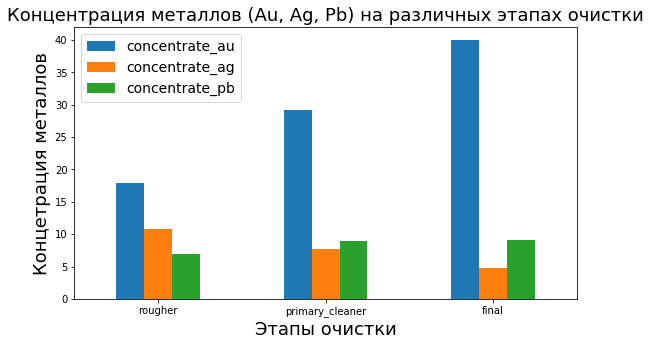

In [19]:
# Нарисуем диаграмму, чтобы наглядно увидеть как менялась концентрация металлов (Au, Ag, Pb)
# на различных этапах очистки
ax = plotdata.plot.bar(figsize=(9,5))
# Добавим подпись диаграмме
ax.set_title('Концентрация металлов (Au, Ag, Pb) на различных этапах очистки', fontsize=18)
# Подпишем оси х и у
ax.set_xlabel('Этапы очистки', fontsize=18)
ax.set_ylabel('Концетрация металлов', fontsize=18)
# Изменим шрифт легенды
ax.legend(fontsize=14)
# Развернем названия этапов из веритиакального положения в горизонтальное
ax.set_xticklabels(index, rotation = 0)

### Вывод

Как видно из таблицы и графиков, картина у нас следующая. Концентрация золота растет, от этапа к этапу. Концентрация серебра, наоборот, снижается от этапа к этапу. А вот концентрация свинца немного увеличивается. Это может быть вызвано как ошибками в лабораторных рассчетов и неверными данными, большим количеством выбросов, или самим технологическим процессом. Либо на каждом этапе свинец добавляется с реагентами для очистки золота, либо реагенты которые должны очищать золото, дополнительно очищают и свинец, поэтому и растет его концентрация.

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.


Следующая задача, это сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Для сравнения нам поможет библиотека seaborn и ее график kdeplot. Данный график - способ что-то понять о распределении, когда неизвестно ничего. Построим два графика, для признака "rougher.input.feed_size" (это и есть пресловутый размер гранул сырья) обучающей и тестовой выборок. Если графики будут похожи, то распределения не сильно отличаются друг от друга, и мы оценка модели не будет искажена. И наоборот, если будут существенные различия, то разница в данных сильно исказит последующую оценку модели.

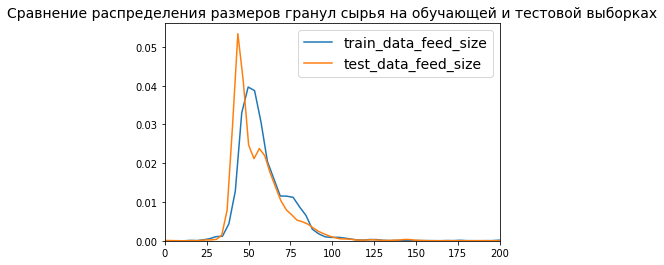

In [20]:
# Построение графиков
ax = sns.kdeplot(train_data['rougher.input.feed_size'])
ax = sns.kdeplot(test_data['rougher.input.feed_size'])
# Введем ограничение по оси, чтобы визуально смотрелось лучше, так как справа получается большая
# пустая область
ax.set_xlim(0, 200)
# Добавим подпись диаграмме
ax.set_title('Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках',
             fontsize=14)
# Изменим легенду, чтобы было понятно, какая линия, что обозначает
ax.legend(['train_data_feed_size', 'test_data_feed_size'], fontsize=14)

Как видно, беспокоиться нам не нужно, распределения очень похожи. Распределение обучающего датасета чуть плавнее, но и значений в нем в 2,5 раза больше, поэтому они не полностью накладываются друг на друга. Перейдем к следующему этапу.

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

Начнем с подсчета суммарной концентрации всех веществ на разных стадиях. Создадим пустой датасет, куда добавим суммарные колонки концентрации веществ по каждому из этапов. После построим диаграмму размаха и посмотрим как у нас будет выглядеть наши данные, и будут ли выбросы

In [21]:
# Создаем пустой датафрейм
summary_concentrate = pd.DataFrame()

# Суммарная концентрация в сырье
summary_concentrate['rougher.input'] = \
full_data['rougher.input.feed_ag'] + \
full_data['rougher.input.feed_au'] + \
full_data['rougher.input.feed_pb'] + \
full_data['rougher.input.feed_sol']

# Суммарная концентрация после флотации
summary_concentrate['rougher.output'] = \
full_data['rougher.output.concentrate_ag'] + \
full_data['rougher.output.concentrate_au'] + \
full_data['rougher.output.concentrate_pb'] + \
full_data['rougher.output.concentrate_sol']

# Суммарная концентрация после первичной очистки
summary_concentrate['primary_cleaner.output'] = \
full_data['primary_cleaner.output.concentrate_ag'] + \
full_data['primary_cleaner.output.concentrate_au'] + \
full_data['primary_cleaner.output.concentrate_pb'] + \
full_data['primary_cleaner.output.concentrate_sol']

# Суммарная концентрация в конце обработки
summary_concentrate['final.output'] = \
full_data['final.output.concentrate_ag'] + \
full_data['final.output.concentrate_au'] + \
full_data['final.output.concentrate_pb'] + \
full_data['final.output.concentrate_sol']

# проверим получившуюся таблицу
summary_concentrate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 4 columns):
rougher.input             22241 non-null float64
rougher.output            22526 non-null float64
primary_cleaner.output    21918 non-null float64
final.output              22328 non-null float64
dtypes: float64(4)
memory usage: 887.3+ KB


In [22]:
# Посморим саму таблицу
summary_concentrate.head()

,rougher.input,rougher.output,primary_cleaner.output,final.output
date,,,,
2016-01-15 00:00:00,51.680034,66.424950,72.640924,63.644396
2016-01-15 01:00:00,50.659114,67.012710,72.543485,63.957723
2016-01-15 02:00:00,50.609929,66.103793,72.095042,64.311180
2016-01-15 03:00:00,51.061546,65.752751,59.957723,63.573449
2016-01-15 04:00:00,47.859163,65.908382,71.321010,64.004667


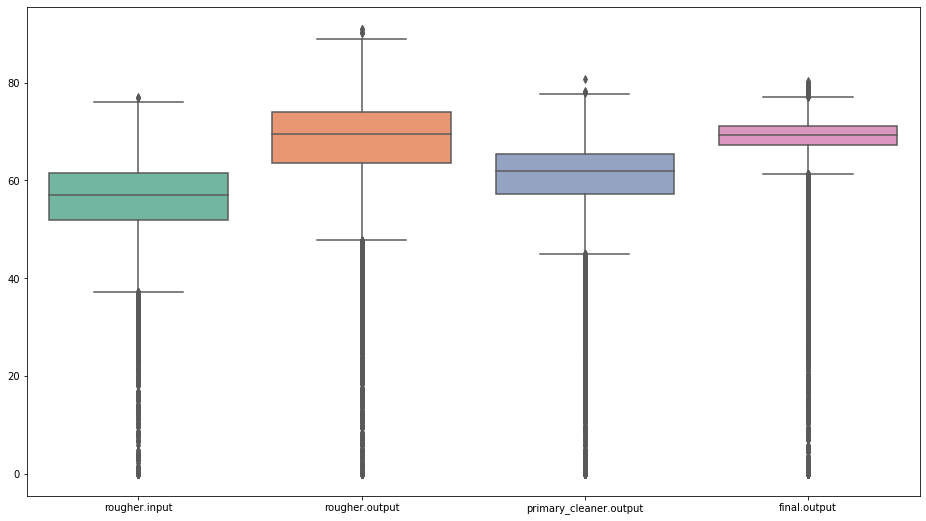

In [23]:
#  Построение диаграммы размаха
plt.figure(figsize=(16, 9))
sns.boxplot(data=summary_concentrate, palette='Set2')

Как видно, выборосы есть и их довольно таки много, причем они непрерывные (выглядят как сплошная жирная линия). Просто так убрать такое количество несовсем целесообразно, так как мы потеряем большу часть данных. Так же, то что мы принимаем за выбросы, может и вовсе оказаться не выбросами. Поэтому в большинстве мы данные трогать не будем. Лучше подойти с другой стороны. Например суммарная концетрация всех веществ, не может быть равна нулю, это уже что-то аномальное. Отберем такие значения, посмотрим сколько их в итоге получится и сохраним индексы этих значений чтобы исключить их из обучающей и тренировочной выборок.

In [24]:
# Выберем все строки нашего датафрейма, где значение хотя бы одного столбца было равно 0
abnormal_values = summary_concentrate.loc[(summary_concentrate['rougher.input'] == 0) | 
                           (summary_concentrate['rougher.output'] == 0) | 
                           (summary_concentrate['primary_cleaner.output'] == 0) | 
                           (summary_concentrate['final.output'] == 0)]
# Выведем на экран полученную таблицу
abnormal_values

,rougher.input,rougher.output,primary_cleaner.output,final.output
date,,,,
2016-01-15 19:00:00,56.005644,62.930764,0.000000,64.546766
2016-01-15 22:00:00,56.038252,62.225893,0.000000,64.554911
2016-01-16 06:00:00,57.764677,62.283147,0.000000,63.765751
2016-01-16 21:00:00,58.602038,0.000000,74.992510,66.175996
2016-01-16 22:00:00,59.921613,0.000000,75.187102,66.794250
...,...,...,...,...
2018-02-11 23:59:59,58.106496,0.000000,68.284696,70.703344
2018-02-12 00:59:59,59.500740,0.000000,68.539751,70.814703
2018-02-12 01:59:59,60.129638,0.000000,69.365785,71.329178


Как видно, в общем датасете 2380 строк имеют аномальные значения, так как суммарная концетрация всех веществ хотя бы в одном из этапов очистки, равна нулю, а такого быть не может. Данные у нас сохранены, теперь эти индексы будем использовать, чтобы найти эти строки в наших обучающей и тестовой выборках и удалить данные наблюдения из выборок.

In [25]:
# Исключаем из обучающей выборки наблюдения с аномальными значениями
good_train_data = train_data.loc[~train_data.index.isin(abnormal_values.index)]
# Посмотрим на результат
good_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13725 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           13725 non-null float64
final.output.concentrate_pb                           13725 non-null float64
final.output.concentrate_sol                          13725 non-null float64
final.output.concentrate_au                           13725 non-null float64
final.output.recovery                                 13725 non-null float64
final.output.tail_ag                                  13725 non-null float64
final.output.tail_pb                                  13725 non-null float64
final.output.tail_sol                                 13725 non-null float64
final.output.tail_au                                  13725 non-null float64
primary_cleaner.input.sulfate                         13725 non-null float64
primary_cleaner.input.depressant                      13725 non-null float64
primary_cleaner.i

In [26]:
# Исключаем из тестовой выборки наблюдения с аномальными значениями
good_test_data = test_data.loc[~test_data.index.isin(abnormal_values.index)]
# Посмотрим на результат
good_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5123 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 54 columns):
primary_cleaner.input.sulfate                 5123 non-null float64
primary_cleaner.input.depressant              5123 non-null float64
primary_cleaner.input.feed_size               5123 non-null float64
primary_cleaner.input.xanthate                5123 non-null float64
primary_cleaner.state.floatbank8_a_air        5123 non-null float64
primary_cleaner.state.floatbank8_a_level      5123 non-null float64
primary_cleaner.state.floatbank8_b_air        5123 non-null float64
primary_cleaner.state.floatbank8_b_level      5123 non-null float64
primary_cleaner.state.floatbank8_c_air        5123 non-null float64
primary_cleaner.state.floatbank8_c_level      5123 non-null float64
primary_cleaner.state.floatbank8_d_air        5123 non-null float64
primary_cleaner.state.floatbank8_d_level      5123 non-null float64
rougher.input.feed_ag                         512

Из обучающей мы потеряли примерно 400 наблюдений (около 3%) а из тестовой около 150 (тоже примерно 3%), это допустимо, зато модель не будет обучаться на аномальных данных, что должно повысить качество нашей модели.

## Вывод

В данном разделе были проанализированы данные, как меняется концентрация разных металлов на каждом этапе очистки. Сравнили распределения размеров гранул сырья на обучающей и тестовой выборках и поняли что аномалий не выявлено. Выявили аномальные значения и исключили их из наших выборок. Далее, самое интересное, можно будет переходить к обучению моделей.

# 3. Модель

### 3.1. Напишите функцию для вычисления итоговой sMAPE.

Обучить модель полдела, еще необходим определить, насколько эффективно модель предсказывает заданные велечины. И если эффективность предсказаний на низком уровне, то и смысла в разработке и внедрении модели нет никакого. Для оценки эффективности предсказаний используются метрики качества. В данной задаче у нас рекомендуется использовать sMAPE, формулы представленые в условии задачи. Перед созданием и тестированием моделей, напишем функцию, которая будет считать нам метрику качества. Напишем две функции, одну для рассчета метрики sMAPE, а вторую для рассчета Итоговой метрики sMAPE, так как потребуется для тестирования и отбора моделей обе функции.

In [27]:
# Функция будет принамать на вход 2 параметра: целевой признак и предсказания для обоих этапов:
# rougher и final
def smape_count(target, prediction):

#     Введем счетчик для подсчета суммы    
    smape_count=0
    
#     Напишем цикл, где будем перебирать все значения признаков и предсказаний по очереди    
    for i in range(len(target)):
        
#     Мы суммируем в счетчике посчитанные значения между разницами в целевом признаке и предсказаниях
        smape_count += (abs(target[i] - prediction[i])) / \
        ((abs(target[i]) + abs(prediction[i])) / 2)

#     Посчитаем значение метрики sMAPE  
    smape = smape_count / len(target) * 100
    
#     Функция возвращает значение метрики sMAPE    
    return smape

Напишем так же функцию, которая будет считать Итоговое значение метрики sMAPE:

In [28]:
# Функция будет принамать на вход 4 параметра: целевые признаки и предсказания для обоих этапов:
# rougher и final
def total_smape_count(target_rougher, prediction_rougher, target_final, prediction_final):

#     Введем два счетчика для каждого из этапов обработки
    smape_count_rougher = 0
    smape_count_final = 0

#     Напишем цикл, где будем перебирать все значения признаков и предсказаний по очереди
    for i in range(len(target_rougher)):

#     Мы суммируем в счетчике посчитанные значения между разницами в целевом признаке и предсказаниях
#     для этапа rougher
        smape_count_rougher += (abs(target_rougher[i] - prediction_rougher[i])) / \
        ((abs(target_rougher[i]) + abs(prediction_rougher[i])) / 2)
    
#     Мы суммируем в счетчике посчитанные значения между разницами в целевом признаке и предсказаниях
#     для этапа final        
        smape_count_final += (abs(target_final[i] - prediction_final[i])) / \
        ((abs(target_final[i]) + abs(prediction_final[i])) / 2)
    
#     Посчитаем значение метрики sMAPE для кажого из этапов   
    smape_rougher = smape_count_rougher / len(target_rougher) * 100
    smape_final = smape_count_final / len(target_rougher) * 100
          
#     Посчитаем, согласно формуле, итоговое значение метрики sMAPE, расставив веса для каждого этапа
    total_smape = 0.25 * smape_rougher + 0.75 * smape_final
    
#     Функция возвращает значение итоговой метрики sMAPE
    return total_smape

Функции написаны, можно переходить к обучению и выбору моделей.

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

Преждем чем переходить к обучению моделей, подготовимся еще немного. Нужно из обучающей выборки убрать все признаки, которых нет в тестовой. Для начала исключим те признаки из обучающей выборки, которых нет в тестовой.

In [29]:
# Создадим список где поместим названия признаков которые есть в обучащей, но нет в тестовой выборках
no_in_good_test_data = good_train_data.columns[~good_train_data.columns.isin(good_test_data.columns)]
# Уберем отсутствующие признаки в тестовой выборке из обучающей
good_train_data = good_train_data.drop(no_in_good_test_data, axis=1)
# Посмотрим на результат
good_train_data.columns.isin(good_test_data.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

Так как все значения в массиве получились True, значит и наборы признаков у нас идентичные, можно переходить дальше.

Далее нужно выделить целевые и общие признаки. Еще одним фактором заслуживающим внимания, является тот факт, что целевых признаков у нас 2, а значит у нас в итоге получится 2 модели, одна для предсказания целевого признака обогащения золота в черновом концентрате, вторая для предсказания целевого признака обогащения золота в финальном концентрате. Поэтому и разбивка у нас будет следующая:

In [30]:
# Отделяем признаки от целевых для обучающей выборки
features_train = good_train_data.drop(['final.output.recovery',
                                       'rougher.output.recovery'], axis=1)
# Выделяем целевой признак для чернового концентрата для обучающей выборки
target_train_rougher = good_train_data['rougher.output.recovery']
# Выделяем целевой признак для финального концентрата для обучающей выборки
target_train_final = good_train_data['final.output.recovery']

# Отделяем признаки от целевых для тестовой выборки
features_test = good_test_data.drop(['final.output.recovery',
                                       'rougher.output.recovery'], axis=1)
# Выделяем целевой признак для чернового концентрата для тестовой выборки
target_test_rougher = good_test_data['rougher.output.recovery']
# Выделяем целевой признак для финального концентрата для тестовой выборки
target_test_final = good_test_data['final.output.recovery']

In [31]:
features_train.shape, features_test.shape

((13725, 52), (5123, 52))

In [32]:
# Зададим парамерт метрики, которую нужно будет использовать для оценки моделей в кроссвалидации
# В данном случае будет считать простой sMAPE и по нему выбирать, какая модель нам больше подойдет
# make_scorer максимизирует метрику, а нам нужно минимальное значение, поэтому используем 
# greater_is_better=Falsе, это настроит функцию на поиск минимального значения метрики
smape_funk = make_scorer(smape_count, greater_is_better=False)

Далее мы пойдем по следующему пути. Изначально хотелось пропустить каждую модель через GridSearchCV и получить уже готовую модель (с подобранными параметрами) для тестирования. Но время которое данная функция затрачивает на постороение просчет всех моделей по заданной сетке параметров ... в общем одно только дерево он мне считал более 3 часов (набор из 4 гиперпараметров) и я так и не дождался результатов. Поэтому было приянто решение пойти следующим путем. Выбрать три модели: Решающее дерево, Случайный лес и Линейная регрессия. Каждую из моделей протестировать на обучающей выборке методом кроссвалидации. Обучающая выборка разбивалась на 4 части и на них проходила обучение и валидацию. Так же методом make_scorer была задана метрика оценки для кроссвалидации, а именно наш sMAPE (обычная функция, не итоговая). Для той модели которая наберет наименьший результат, сделать подбор памараметров и уже с подобранными гиперпараметрами обучить ее заново на всем обучающем датасете. После протестировать на тестовой выборке и посчитать Итоговый sMAPE.

Начнем с Решающего дерева:

In [33]:
%%time

# определим модель решающего дерева, зафиксируем параметр random_state, чтобы результаты были 
# повторяемые
model_tree = DecisionTreeRegressor(random_state=42)

# Посчитаем методом кроссвалидации значения метрики sMAPE для чернового и финального концентратов
print("Значение метрики sMAPE для чернового концентрата:", 
      cross_val_score(model_tree, features_train, 
                      target_train_rougher, cv=4, 
                      scoring=smape_funk, n_jobs=-1).mean())

print("Значение метрики sMAPE для финального концентрата:", 
      cross_val_score(model_tree, features_train, 
                      target_train_final, cv=4, 
                      scoring=smape_funk, n_jobs=-1).mean())

Значение метрики sMAPE для чернового концентрата: -11.000309253117326
Значение метрики sMAPE для финального концентрата: -15.966194587653328
CPU times: user 8.4 s, sys: 12.4 ms, total: 8.42 s
Wall time: 8.53 s


Далее посчитаем метрики для Линейной регрессии:

In [34]:
%%time

# определим модель Линейной регрессии
model_reg = LinearRegression()

# Посчитаем методом кроссвалидации значения метрики sMAPE для чернового и финального концентратов
print("Значение метрики sMAPE для чернового концентрата:",
      cross_val_score(model_reg, features_train, 
                      target_train_rougher, cv=4, 
                      scoring=smape_funk, n_jobs=-1).mean())

print("Значение метрики sMAPE для финального концентрата:", 
      cross_val_score(model_reg, features_train, 
                      target_train_final, cv=4, 
                      scoring=smape_funk, n_jobs=-1).mean())

Значение метрики sMAPE для чернового концентрата: -7.74142993149129
Значение метрики sMAPE для финального концентрата: -10.87618173670361
CPU times: user 2.12 s, sys: 1.26 s, total: 3.38 s
Wall time: 3.35 s


Ну и конечно же, всеми любимый, Случайный лес:

In [35]:
%%time

# определим модель Случайного леса, зафиксируем параметр random_state, чтобы результаты были 
# повторяемые
model_forest = RandomForestRegressor(random_state=42)

print("Значение метрики sMAPE для чернового концентрата:", 
      cross_val_score(model_forest, features_train, 
                      target_train_rougher, cv=4, 
                      scoring=smape_funk, n_jobs=-1).mean())

print("Значение метрики sMAPE для финального концентрата:", 
      cross_val_score(model_forest, features_train, 
                      target_train_final, cv=4, 
                      scoring=smape_funk, n_jobs=-1).mean())

Значение метрики sMAPE для чернового концентрата: -7.731735486710512
Значение метрики sMAPE для финального концентрата: -11.084648882036863
CPU times: user 45 s, sys: 0 ns, total: 45 s
Wall time: 45.6 s


С одной строны, выиграла Линейная регрессия, так как показатель метирики по черновому концентрату лишь на 0.01 превышает показатель что получился у Случайного леса, а по финальному концентрату у Линейной модели результат куда лучше. Так же время работы модели 3.66 секунд, против 52.5 секунд у Леса, что тоже не говорит в его пользу. Но есть одно но, которое тоже обязательно нужно учесть. Мы тестировали модели, без учета подбора гиперпараметров. Для Линейной регрессии все и так нормально, там менять то нечего, а гиперпараметры normalize и n_jobs никак не влияют на конечную цифру метрики. А вот в случае с Лесом, здесь за счет грамотного подбора гиперпараметров можно существенно улушить результат. Поэтому далее преступим к тестированию Линейной регрессии на тестовой выборке. Параллельно создадим случайную модель - создадим две Серии, по размеру равные нашим таргетам, заполним их средними значениями таргетов и посчитаем Итоговое значение метрики для этой случайной модели.

In [34]:
# Создаем обеъкт Серию, размерностью с цеоевой признак и заполненную средним значением целевого
# тестового признака для чернового концентрата
mean_series_rougher = pd.Series([target_test_rougher.mean() 
                                 for i in range(len(target_train_rougher))]).values

# Создаем обеъкт Серию, размерностью с цеоевой признак и заполненную средним значением целевого
# тестового признака для финального концентрата
mean_series_final = pd.Series([target_test_final.mean() 
                               for i in range(len(target_train_final))]).values

In [35]:
# Задаем случайную модель и посчитаем дя нее значение метрики Итогового sMAPE
random_model = total_smape_count(target_test_rougher, mean_series_rougher, 
                                 target_test_final, mean_series_final)
# Выведем на экран полученное значение
print("Итоговое значение метрики sMAPE для случайной модели:", random_model)

Итоговое значение метрики sMAPE для случайной модели: 6.8493735269389315


In [36]:
# Задаем две модели Линейной регрессии для чернового и финального концентратов
model_reg_rougher = LinearRegression()
model_reg_final = LinearRegression()

# Обучим каждую из моделей на всей тестовой выборке
model_reg_rougher.fit(features_train, target_train_rougher)
model_reg_final.fit(features_train, target_train_final)

# Запишем предсказания моделей в отдельные переменные
predict_rougher = model_reg_rougher.predict(features_test)
predict_final = model_reg_final.predict(features_test)

# Посчитаем значение метрики Итогового sMAPE для Линейной регрессии
reg_model = total_smape_count(target_test_rougher, predict_rougher, target_test_final, predict_final)
print("Итоговое значение метрики sMAPE для Линейной регрессии:", reg_model)

Итоговое значение метрики sMAPE для Линейной регрессии: 7.316037194142501


Как видно, Линейная регрессия не справилась и метрика у нее получилась хуже, чем у случайной модели. На втором месте у нас был Случайный лес, значит нужно у него сделать подбор параметров и обучить на обучающей выборке и протестировать на тестовой, а потом сравнить полученное значение метрики с занчением случайной модели. Для перебора параметров модели, воспользуемся GridSearchCV. Зададим диапазон для нескольких гиперпараметров и с помощью кроссвалидации, получим наилучшее соотношение данных гиперпарамтров дающих наименьшее значение метрики. Эту операцию проделаем два раза, для чернового концентрата и для финального. Начнем для чернового концентрата.

In [37]:
%%time

# Определим модель
clf = RandomForestRegressor(random_state=42)

# зададим сетку гиперпараметров
parametrs = {
#     "criterion": ['mse'],
    "max_depth": [5, 30],
    "n_estimators": [30, 70],
    "min_samples_split": [2, 15],
    }

# зададим параметры для обучения,в scoring зададим наше значение метрики sMAPE
# grid_rougher = GridSearchCV(clf, parametrs, cv=4, n_jobs=-1, scoring=smape_funk)
# grid_rougher.fit(features_train, target_train_rougher)

# выведем лучшие параметры для нашей модели
# grid_rougher.best_params_

CPU times: user 42 µs, sys: 2 µs, total: 44 µs
Wall time: 47.9 µs


Модель побрает параметры очень не быстро, и делал все локально. Причем поставил на пересчет, и обрабаотывает он эти значения по несколько часов на 6 ядерном процессоре в 12 поточном режиме (проклял все на свете:)), поэтому сам алогритм рассчета GridSearchCV закомментировал, чтобы не состарится пока этот ноутбук на этом сайте отработает (по времени, разница составляла локально - 1 минута, через яндекс практикум - 10 минут)

Поэтому отправляю в таком варианте

In [38]:
%%time
# Зададим нашей модели для черного концентрата подобранные гиперпараметры
model_forest_rougher = RandomForestRegressor(random_state=42,
                                          criterion = 'mse',
                                          n_estimators = 50,
                                          max_depth = 20,
                                          min_samples_split = 10,
                                          n_jobs = -1)

# Обучим модель на обучающей выборке
model_forest_rougher.fit(features_train, target_train_rougher)

# Сохраним предсказаные значения на тестовой выборке
predict_rougher = model_forest_rougher.predict(features_test)

# Посчитаем занчение метрики для чернового концентрата
smape_count(target_test_rougher, predict_rougher)

CPU times: user 38.4 s, sys: 48.4 ms, total: 38.5 s
Wall time: 39.2 s


4.253185324138537

In [39]:
%%time
# Определим модель
clf_final = RandomForestRegressor(random_state=42)

# зададим сетку гиперпараметров
parametrs = {
#     "criterion": ['mse'],
    "max_depth": range(2, 30),
    "n_estimators": range(50, 100),
    "max_features": range(5, 30),
    "min_samples_split": range(2, 15),
#     "min_samples_leaf": range(1, 15),
#     "max_leaf_nodes": range(10, 200)
    }

# зададим параметры для обучения,в scoring зададим наше значение метрики sMAPE
# grid_final = GridSearchCV(clf_final, parametrs, cv=4, n_jobs=-1, scoring=smape_funk)
# grid_final.fit(features_train, target_train_final)

# выведем лучшие параметры для нашей модели
# grid_final.best_params_

CPU times: user 69 µs, sys: 2 µs, total: 71 µs
Wall time: 77 µs


In [40]:
%%time
# Зададим нашей модели финанльного концентрата подобранные гиперпараметры
model_forest_final = RandomForestRegressor(random_state=42, 
                                          criterion = 'mse',
                                          n_estimators = 90,
                                          max_depth = 2,
                                          max_features = 30,
                                          min_samples_split = 2,
                                          n_jobs = -1)

# Обучим модель на обучающей выборке
model_forest_final.fit(features_train, target_train_final)

# Сохраним предсказаные значения на тестовой выборке
predict_final = model_forest_final.predict(features_test)

# Посчитаем занчение метрики для финального концентрата
smape_count(target_test_final, predict_final)

CPU times: user 6.85 s, sys: 7.57 ms, total: 6.86 s
Wall time: 6.91 s


7.39841710727288

In [41]:
# Посчитаем значение метрики Итогового sMAPE
total_smape_count(target_test_rougher, predict_rougher, target_test_final, predict_final)

6.612109161489293

## Вывод

Модель случайного леса в очередной раз оказалсь лучше всех. С помощью подбора гиперпараметров получилось довести значение нашей метрики качества, ниже, чем у случайной модели. Как следствие с моделью лучше, чем без нее, а значит можно отправлять в продакшн.